In [47]:
import quantstats as qs
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff
import datetime as dt

import numpy as np 
# Used to grab the stock prices, with yahoo 
import pandas_datareader as web 
#from datetime import datetime 
# To visualize the results 
import matplotlib.pyplot as plt 
import seaborn
import quantstats as qs

class StockAnalysis:
    def __init__(self,tickers,start_date=None):
        if(start_date == None):
            self.start = dt.datetime.now() - dt.timedelta(days=7*365)
        else:
            self.start=start_date
        self.tickers = tickers
         
        self.data = self.get_data()

    # gets data from yahoo finance
    def get_data(self,data_source = "yahoo",tickers= []):
        symbols=[]
        if(len(tickers) == 0):
            tickers=self.tickers

        for ticker in tickers:  
            try:   
                r = web.DataReader(ticker,data_source, self.start) 
            except :
                print(ticker)
            
                continue  
            # add a symbol column   
            r['Symbol'] = ticker    
            symbols.append(r)
        # concatenate into df
        df = pd.concat(symbols)
        df = df.reset_index()
        df = df[['Date', 'Close', 'Symbol']]
        df_pivot=df.pivot('Date','Symbol','Close').reset_index()
        df_pivot.set_index("Date",inplace=True)
        return df_pivot

    # add more stocks
    def addTicker(self,ticker):
        self.tickers += ticker
        self.get_data()

    # get cporrelation metween all stocks added
    def correlation_matrix(self):
        # we are using pearson correlation coefficient
        corr_df = self.data.corr(method='pearson')
        #reset symbol as index (rather than 0-X)
        corr_df.head().reset_index()
        #del corr_df.index.name
        plt.figure(figsize=(13, 8))
        seaborn.heatmap(corr_df, annot=True, cmap='RdYlGn')
        plt.figure()

        return corr_df
    
    # get correlation matrix between two stocks
    def correlationTwoStocks(self,stock1,stock2):
        symbols = [stock1,stock2]
        data = self.get_data(tickers=symbols)
        corr_df = data.corr(method='pearson')
        #reset symbol as index (rather than 0-X)
        corr_df.head().reset_index()
        #del corr_df.index.name
        return corr_df

    # sharpe ratio for all stocks
    def getSharpeRatio(self):
        
        return qs.stats.sharpe(self.data)


# fama - french 3 factor model data from python famafrenchfactor library
    def getfamaFrench3FactorData(self):
        ff3_monthly = gff.famaFrench3Factor(frequency='m')
        ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
        ff3_monthly.set_index('Date', inplace=True)
        
        return ff3_monthly

# fama-french 3 factor model expected yealry return for aparticular stock
    def yearlyExpectedReturnsFamaFrench(self,ticker):
        ff3_monthly = self.getfamaFrench3FactorData()
        if(ticker not in self.tickers):
            print("Ticker not present")
            return None
        # getting ticker data
        stock_returns = self.data[ticker].resample('M').last().pct_change().dropna() # calculate the percentage change of the last price of monthly data compared with the previous month.
        stock_returns.name = "Month_Rtn"
        ff_data = ff3_monthly.merge(stock_returns,on='Date') # merge the calculated stock returns data with the Fama-French benchmark dataframe.
        # ff_data.head()

        # running linear regression to find the beta coefficients
        X = ff_data[['Mkt-RF', 'SMB', 'HML']] 
        y = ff_data['Month_Rtn'] - ff_data['RF'] 
        X = sm.add_constant(X) # addding constant 
        ff_model = sm.OLS(y, X).fit()
        print(ff_model.summary())
        intercept, b1, b2, b3 = ff_model.params

        # calculating expected eyarly returns
        rf = ff_data['RF'].mean()
        market_premium = ff3_monthly['Mkt-RF'].mean()
        size_premium = ff3_monthly['SMB'].mean()
        value_premium = ff3_monthly['HML'].mean()

        expected_monthly_return = rf + b1 * market_premium + b2 * size_premium + b3 * value_premium 
        expected_yearly_return = expected_monthly_return * 12
        print("Expected yearly return: " + str(expected_yearly_return))

        return expected_yearly_return

    def basic_metrics(self):
        #data=pd.DataFrame(index = self.data.columns)
        metrics = []
        for i in self.data.columns:
            metric= qs.reports.metrics(self.data[i],mode='basic',display=False)
            metrics.append(metric)

        data = pd.concat(metrics,axis=1)

        data.columns = self.data.columns
        
        return data


In [2]:
import pandas as pd
tickers = pd.read_excel("BidAskVolume.xlsx")
tickers=list(tickers.loc[1].dropna().drop_duplicates().values)
tickers=[i.split()[0] for i in tickers]
len(tickers)
# update tickers
tickers.remove("RFMD")
tickers.append("BSL")
tickers.remove("SIA")
tickers.append("C6L.SI")
tickers.remove("7203")
tickers.append("7203.T")
tickers

['AAPL',
 'MU',
 'NVDA',
 'LMT',
 'BA',
 'CSCO',
 'CRWD',
 'PANW',
 'ZS',
 'NEE',
 'BEPC',
 'XOM',
 'VBR',
 'DBS',
 'JPM',
 'FUTU',
 'YUMC',
 'JNJ',
 'TMO',
 'TCEHY',
 'TCOM',
 'ADBE',
 'IBM',
 'BIDU',
 'FTNT',
 'SBUX',
 'PEP',
 'MA',
 'BSL',
 'C6L.SI',
 '7203.T']

In [48]:
analyser = StockAnalysis(tickers=tickers)

Symbol,7203.T,AAPL,ADBE,BA,BEPC,BIDU,BSL,C6L.SI,CRWD,CSCO,...,PANW,PEP,SBUX,TCEHY,TCOM,TMO,VBR,XOM,YUMC,ZS
Symbol,,,,,,,,,,,,,,,,,,,,,
7203.T,1.000000,0.879813,0.723645,-0.090371,-0.413908,-0.162785,-0.263869,-0.611783,0.691934,0.622411,...,0.933336,0.861861,0.666255,0.409131,-0.597288,0.862801,0.844762,-0.033403,0.508154,0.779724
AAPL,0.879813,1.000000,0.898051,-0.186912,-0.248588,-0.253086,-0.455559,-0.867589,0.844557,0.663936,...,0.940417,0.936695,0.809513,0.642889,-0.709916,0.985546,0.795990,-0.363768,0.712257,0.909894
ADBE,0.723645,0.898051,1.000000,0.047999,0.174990,-0.242621,-0.359816,-0.863092,0.824689,0.796547,...,0.786164,0.827097,0.892178,0.806788,-0.692069,0.928494,0.734010,-0.619188,0.855380,0.912366
BA,-0.090371,-0.186912,0.047999,1.000000,0.444716,0.211302,0.518244,0.290464,-0.380990,0.495861,...,-0.136002,-0.099578,0.034203,0.229388,0.075852,-0.114019,0.190084,0.010113,-0.132188,-0.610923
BEPC,-0.413908,-0.248588,0.174990,0.444716,1.000000,0.631325,0.110787,-0.145190,0.332214,-0.102959,...,-0.291523,-0.445125,0.382447,0.580559,0.516948,-0.199956,-0.001086,-0.436243,0.472884,0.032338
BIDU,-0.162785,-0.253086,-0.242621,0.211302,0.631325,1.000000,0.530045,0.413425,0.639066,-0.213362,...,-0.234315,-0.434763,-0.299269,0.135005,0.630185,-0.306900,0.101112,0.240127,-0.079583,-0.005591
BSL,-0.263869,-0.455559,-0.359816,0.518244,0.110787,0.530045,1.000000,0.671219,0.199848,-0.032772,...,-0.372162,-0.430153,-0.309131,-0.208808,0.629578,-0.456343,0.107217,0.449464,-0.469595,-0.207460
C6L.SI,-0.611783,-0.867589,-0.863092,0.290464,-0.145190,0.413425,0.671219,1.000000,-0.486486,-0.532521,...,-0.709763,-0.798221,-0.751472,-0.697872,0.755643,-0.870924,-0.483737,0.672608,-0.721276,-0.699642
CRWD,0.691934,0.844557,0.824689,-0.380990,0.332214,0.639066,0.199848,-0.486486,1.000000,0.471869,...,0.763648,0.602505,0.709622,0.441707,-0.030325,0.865794,0.809971,0.118825,0.643084,0.921373


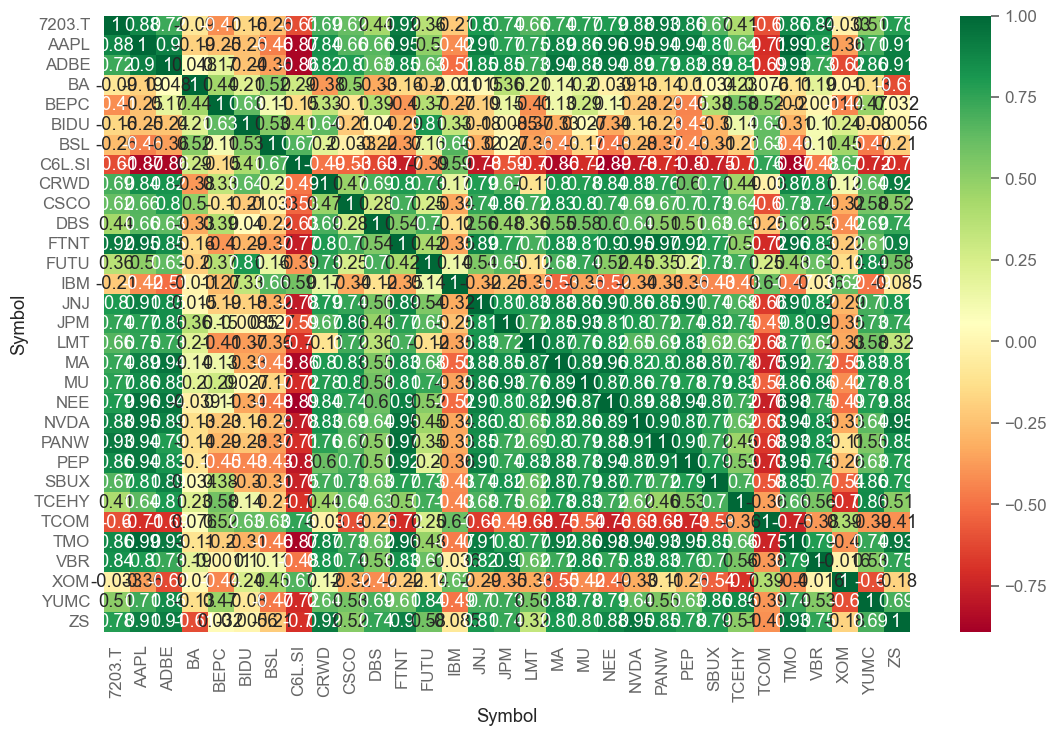

<Figure size 1000x600 with 0 Axes>

In [49]:
correlations=analyser.correlation_matrix()
correlations

In [50]:
upper_corr_mat = correlations.where(
    np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
  
# Convert to 1-D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()
  
# Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values(ascending=False)


/var/folders/5r/z92hbcf14gx38w5z2nf1210w0000gn/T/ipykernel_15264/3634194390.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.triu(np.ones(correlations.shape), k=1).astype(np.bool))


In [54]:
len(sorted_mat[sorted_mat>0.9])

35

In [64]:
diversification = {}

for i in sorted_mat[sorted_mat>0.9].index.to_list():
    if(i[0] in diversification):
        diversification[i[0]].append(i[1])
    else:
        diversification[i[0]] = [i[1]]
diversification

{'TMO': ['AAPL', 'NEE', 'FTNT', 'PEP', 'NVDA', 'PANW', 'ADBE', 'MA', 'JNJ'],
 'PANW': ['FTNT', 'AAPL', '7203.T', 'NVDA'],
 'NEE': ['AAPL', 'MA', 'ADBE', 'JNJ', 'FTNT'],
 'FTNT': ['AAPL', '7203.T'],
 'NVDA': ['FTNT', 'AAPL'],
 'ZS': ['NVDA', 'TMO', 'CRWD', 'ADBE', 'AAPL'],
 'MA': ['ADBE'],
 'PEP': ['AAPL', 'NEE', 'FTNT', 'JNJ', 'PANW'],
 'MU': ['JPM'],
 'JNJ': ['AAPL']}

In [42]:
tickers_final = ['AAPL','NVDA','BA','CSCO','NEE','VBR','DBS','JPM','YUMC','TCEHY','ADBE','FTNT','SBUX','MA','BSL','C6L.SI']

In [68]:
sharpes = analyser.getSharpeRatio()
sharpes

Symbol
7203.T    0.281849
AAPL      0.925373
ADBE      0.703112
BA        0.202780
BEPC      0.108838
BIDU     -0.022751
BSL      -0.090343
C6L.SI   -0.299521
CRWD      0.534551
CSCO      0.345334
DBS       0.152128
FTNT      0.937295
FUTU      0.463230
IBM       0.128356
JNJ       0.491026
JPM       0.456949
LMT       0.539554
MA        0.687132
MU        0.596023
NEE       0.723813
NVDA      1.064359
PANW      0.600688
PEP       0.484741
SBUX      0.283317
TCEHY     0.291938
TCOM     -0.017719
TMO       0.881641
VBR       0.365473
XOM       0.275737
YUMC      0.340530
ZS        0.662766
dtype: float64

In [58]:
sharpes['AAPL']

0.9253733476328069

In [67]:
remove= []
for i in tickers_final:
    if(i in diversification):
        for j in diversification[i]:
            if(j in tickers_final):
                if(sharpes[i] > sharpes[j]):
                    print(i,j)
                    remove.append(j)

NVDA FTNT
NVDA AAPL
NEE MA
NEE ADBE
FTNT AAPL


In [66]:
set(remove)

{'AAPL', 'ADBE', 'FTNT', 'MA'}